In [1]:
import os
import shutil
from PIL import Image
import random
import math
import tensorflow as tf
import pathlib
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython import display

import time
import datetime
import zipfile

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from keras import backend

import shutil

import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

2023-09-10 21:47:50.617157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SPLIT_SIZE_IMAGE = 512
IMAGE_PATH = "output/"
TRAIN_PATH = "dataset_landcover/train/"
TEST_PATH = "dataset_landcover/test/"
EVAL_PATH = "dataset_landcover/eval/"
PREPARE_DATASET = False
BATCH_SIZE = 1
BUFFER_SIZE = 400
LAMBDA = 100

In [4]:
if PREPARE_DATASET: 
    !curl -o landcover.ai.v1.zip https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip

In [5]:
if PREPARE_DATASET: 
    # Chemin du fichier ZIP que vous avez téléchargé
    zip_file_path = "landcover.ai.v1.zip"

    # Chemin du répertoire où vous souhaitez extraire les fichiers
    extracted_folder_path = "landcover"

    # Fonction pour décompresser le fichier ZIP
    def unzip_file(zip_path, extract_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

    # Appel de la fonction pour décompresser le fichier
    unzip_file(zip_file_path, extracted_folder_path)

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


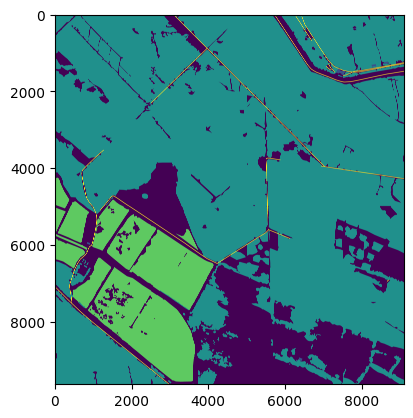

<Axes: >

In [6]:
import rasterio
from rasterio.plot import show
fp = "landcover/masks/M-33-20-D-c-4-2.tif"
img = rasterio.open(fp)
show(img)

In [7]:

if PREPARE_DATASET: 
    folder_path = 'landcover/masks'

    # Liste tous les fichiers dans le dossier spécifié
    file_list = os.listdir("landcover/masks/")

    # Affiche la liste des noms de fichiers
    for filename in file_list:
        img = rasterio.open("landcover/masks/" + filename)
        # Récupérer les dimensions de l'image
        img_width, img_height = img.width, img.height

        # Créer une nouvelle figure avec les dimensions spécifiques en pixels
        fig = plt.figure(figsize=(img_width, img_height), dpi=1)

        # Ajouter un axe à la figure
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis('off')  # Désactiver les graduations (axes)

        # Afficher l'image sur l'axe spécifié
        show(img, ax=ax)

        # Sauvegarder la figure en tant qu'image PNG
        fig.savefig("landcover/masks/" + filename, format='tiff', dpi=1)

        # Fermer la figure pour éviter l'affichage
        plt.close(fig)

In [8]:
if PREPARE_DATASET: 
    %run landcover/split.py

In [9]:
def merge_image(img1_path, img2_path, new_image_path):
    image1 = Image.open(img1_path)
    image2 = Image.open(img2_path)
    
    #resize, first image
    image1 = image1.resize((SPLIT_SIZE_IMAGE, SPLIT_SIZE_IMAGE))
    image1_size = image1.size
    image2_size = image2.size
    new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
    new_image.paste(image1,(0,0))
    new_image.paste(image2,(image1_size[0],0))
    new_image.save(new_image_path,"JPEG")

In [10]:
def create_image(from_image, to_image, new_image_name):
        merge_image(
            from_image,
            to_image,
            TRAIN_PATH + new_image_name
        )

In [11]:
if PREPARE_DATASET: 
    os.makedirs(TRAIN_PATH)
    os.makedirs(TEST_PATH)
    os.makedirs(EVAL_PATH)

In [12]:
if PREPARE_DATASET: 
    file_train = open("landcover/train.txt", 'r')
    lines = file_train.readlines()

    # Strips the newline character
    for line in tqdm(lines):
        merge_image(
            IMAGE_PATH + line.strip() + '.jpg',
            IMAGE_PATH + line.strip() + '_m.png',
            TRAIN_PATH + line.strip() + ".png"
        )

In [13]:
if PREPARE_DATASET: 
    file_train = open("landcover/val.txt", 'r')
    lines = file_train.readlines()

    # Strips the newline character
    for line in tqdm(lines):
        merge_image(
            IMAGE_PATH + line.strip() + '.jpg',
            IMAGE_PATH + line.strip() + '_m.png',
            EVAL_PATH + line.strip() + ".png"
        )

In [14]:
if PREPARE_DATASET: 
    file_train = open("landcover/test.txt", 'r')
    lines = file_train.readlines()

    # Strips the newline character
    for line in tqdm(lines):
        merge_image(
            IMAGE_PATH + line.strip() + '.jpg',
            IMAGE_PATH + line.strip() + '_m.png',
            TEST_PATH + line.strip() + ".png"
        )

(512, 1024, 3)


2023-08-27 11:27:39.269733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 11:27:39.322259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 11:27:39.322494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 11:27:39.324365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 11:27:39.324538: I tensorflow/compile

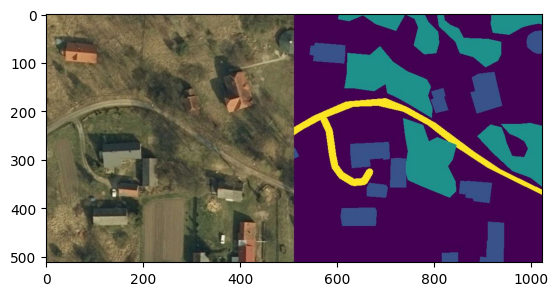

In [15]:
sample_image = tf.io.read_file(TRAIN_PATH + 'M-33-7-A-d-3-2_106.png')
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

plt.figure()
plt.imshow(sample_image)

In [3]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image,
        [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image,
        [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image, real_image

In [4]:
DATASET_IMG_SIZE = 256
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image,
        size=[2, DATASET_IMG_SIZE, DATASET_IMG_SIZE, 3]
    )

    return cropped_image[0], cropped_image[1]

In [5]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [6]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [7]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return random_jitter(input_image, real_image)

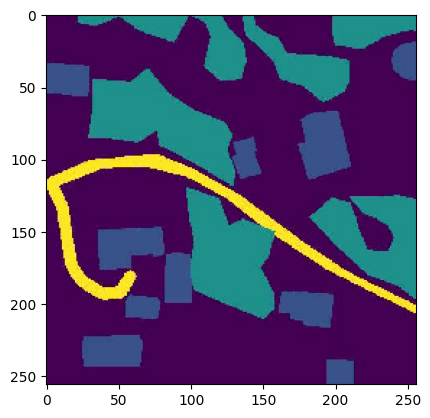

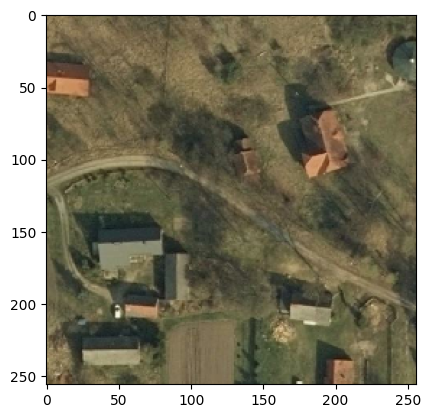

In [21]:
inp, re = load(TRAIN_PATH + 'M-33-7-A-d-3-2_106.png')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

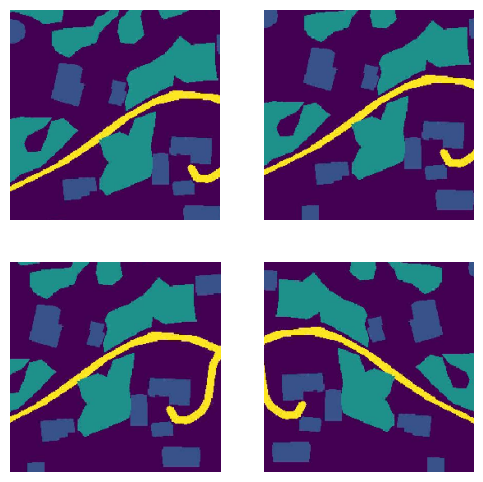

In [22]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [8]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [9]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(
        input_image,
        real_image,
        DATASET_IMG_SIZE,
        DATASET_IMG_SIZE
    )
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [10]:
train_dataset = tf.data.Dataset.list_files(TRAIN_PATH + "*.png")
train_dataset = train_dataset.map(
    load_image_train,
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

2023-09-10 21:48:22.930858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 21:48:22.981839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 21:48:22.982088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 21:48:22.984517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 21:48:22.984704: I tensorflow/compile

In [11]:
test_dataset = tf.data.Dataset.list_files(TEST_PATH + "*.png")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [27]:
eval_dataset = tf.data.Dataset.list_files(EVAL_PATH + "*.png")
eval_dataset = eval_dataset.map(
    load_image_train,
    num_parallel_calls=tf.data.AUTOTUNE
)
eval_dataset = eval_dataset.shuffle(BUFFER_SIZE)
eval_dataset = eval_dataset.batch(BATCH_SIZE)

In [28]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2023-08-27 11:27:50.953000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


(1, 128, 128, 3)


In [29]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.8))

    result.add(tf.keras.layers.ReLU())

    return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [30]:
def residual_block_down(filters, size):
    result = tf.keras.Sequential()

    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same'))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same'))
    result.add(tf.keras.layers.BatchNormalization())

    def block(x):
        y = result(x)
        if x.shape[3] != y.shape[3]:  # Vérifie si les canaux sont incompatibles
            x = tf.keras.layers.Conv2D(filters, 1, strides=1, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
        y = tf.keras.layers.add([x, y])  # Concaténation résiduelle
        y = tf.keras.layers.ReLU()(y)
        # Squeeze-and-Excitation (SE) block
        se = tf.keras.layers.GlobalAveragePooling2D()(y)
        se = tf.keras.layers.Dense(filters // 8, activation='relu')(se)
        se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
        se = tf.keras.layers.Reshape((1, 1, filters))(se)
        y = tf.keras.layers.Multiply()([y, se])

        return y

    return block
def residual_block_up(filters, size):
    result = tf.keras.Sequential()

    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=1, padding='same'))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=1, padding='same'))
    result.add(tf.keras.layers.BatchNormalization())

    def block(x):
        y = result(x)
        if x.shape[3] != y.shape[3]:  # Vérifie si les canaux sont incompatibles
            x = tf.keras.layers.Conv2DTranspose(filters, 1, strides=1, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
        y = tf.keras.layers.add([x, y])  # Concaténation résiduelle
        y = tf.keras.layers.ReLU()(y)
        # Squeeze-and-Excitation (SE) block
        se = tf.keras.layers.GlobalAveragePooling2D()(y)
        se = tf.keras.layers.Dense(filters // 8, activation='relu')(se)
        se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
        se = tf.keras.layers.Reshape((1, 1, filters))(se)
        y = tf.keras.layers.Multiply()([y, se])
        return y
    
    return block

In [31]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        residual_block_down(128, 4),
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        residual_block_down(256, 4),
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        residual_block_down(512, 4),
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        residual_block_down(512, 4),
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        residual_block_up(512, 4),
        upsample(512, 4),  # (batch_size, 32, 32, 1024)
        residual_block_up(512, 4),
        upsample(256, 4),  # (batch_size, 64, 64, 512)
        residual_block_up(256, 4),
        upsample(128, 4),  # (batch_size, 128, 128, 256)
        residual_block_up(128, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh'
    )  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

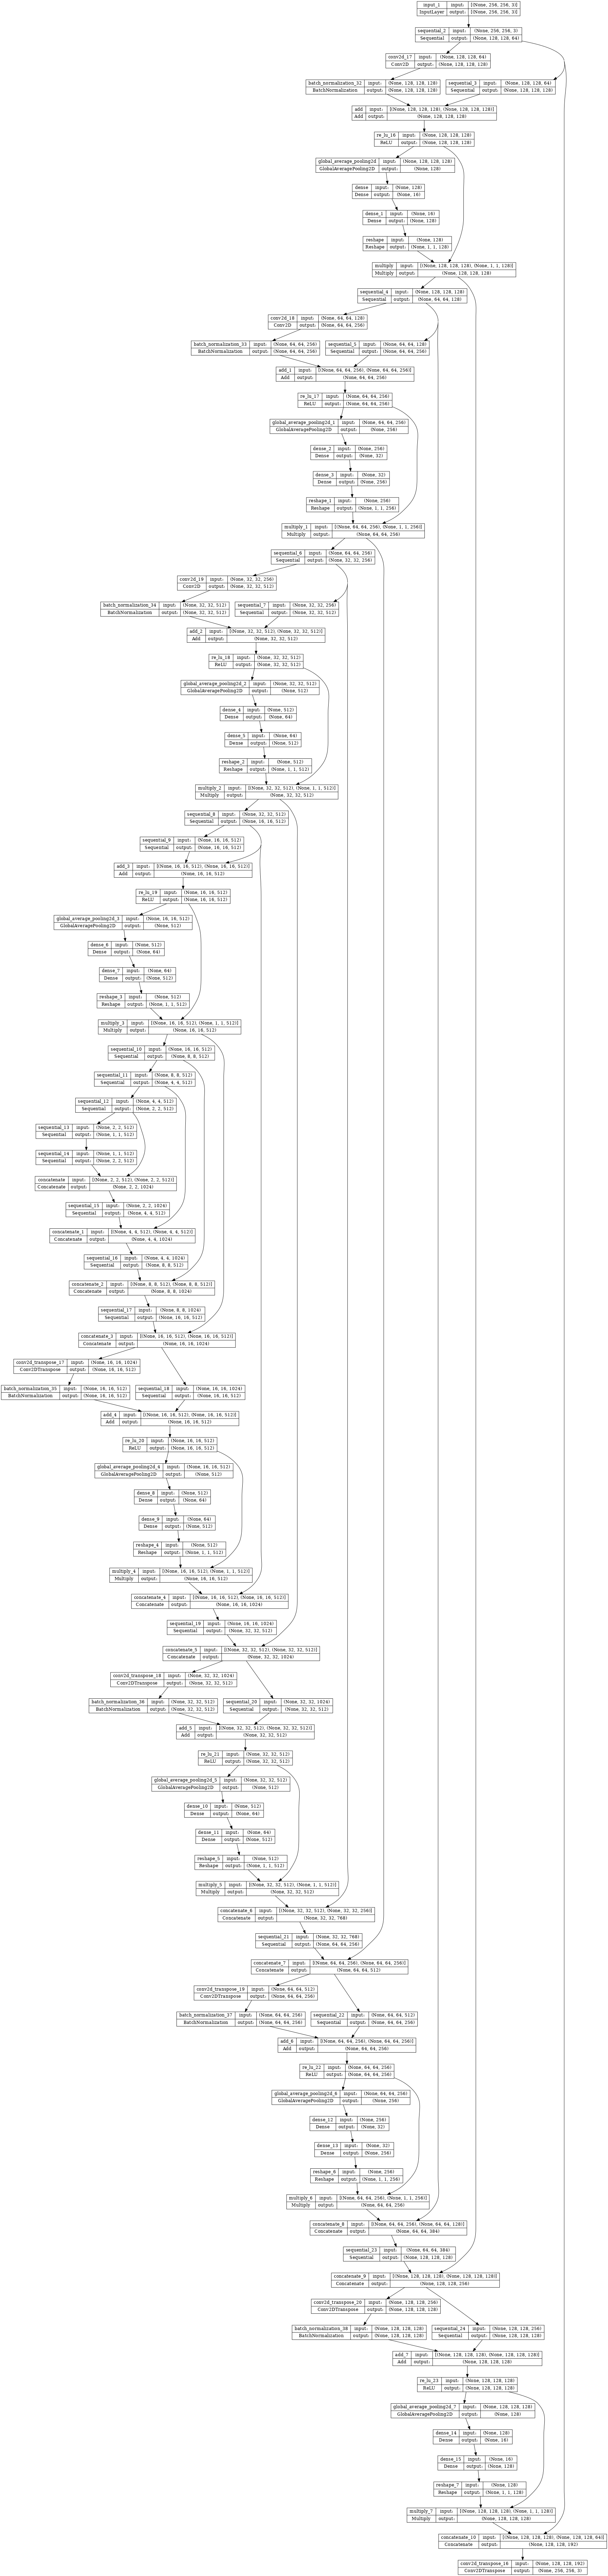

In [32]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

2023-08-27 11:27:57.209423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


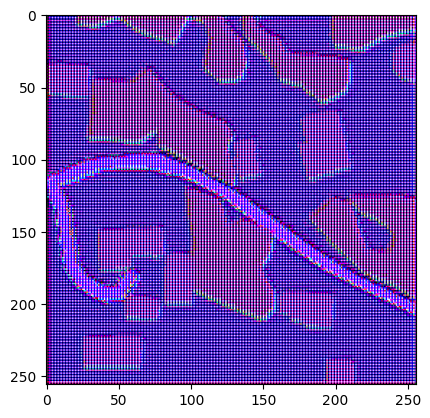

In [33]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [34]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

# def kl_divergence_loss(target, generated):
#     target_probs = target / tf.reduce_sum(target, axis=-1, keepdims=True)
#     generated_probs = generated / tf.reduce_sum(generated, axis=-1, keepdims=True)
#     return tf.reduce_mean(tf.reduce_sum(target_probs * tf.math.log(target_probs / generated_probs), axis=-1))

In [35]:
# def generator_loss(disc_generated_output, gen_output, target):
#     gan_loss = wasserstein_loss(tf.ones_like(disc_generated_output), disc_generated_output)

#     # Mean absolute error
#     l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

#     total_gen_loss = gan_loss + (LAMBDA * l1_loss)

#     return total_gen_loss, gan_loss, l1_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = -tf.reduce_mean(disc_generated_output)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


In [36]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    res1 = residual_block_down(64, 4)(down1)
    down2 = downsample(128, 4)(res1)  # (batch_size, 64, 64, 128)
    res2 = residual_block_down(128, 4)(down2)
    down3 = downsample(256, 4)(res2)  # (batch_size, 32, 32, 256)
    res3 = residual_block_down(256, 4)(down3)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(res3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4,
        strides=1,
        kernel_initializer=initializer,
        use_bias=False
    )(zero_pad1)  # (batch_size, 31, 31, 512)
    res4 = residual_block_down(512, 4)(conv)
    batchnorm1 = tf.keras.layers.BatchNormalization()(res4)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1,
        4,
        strides=1,
        kernel_initializer=initializer
    )(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

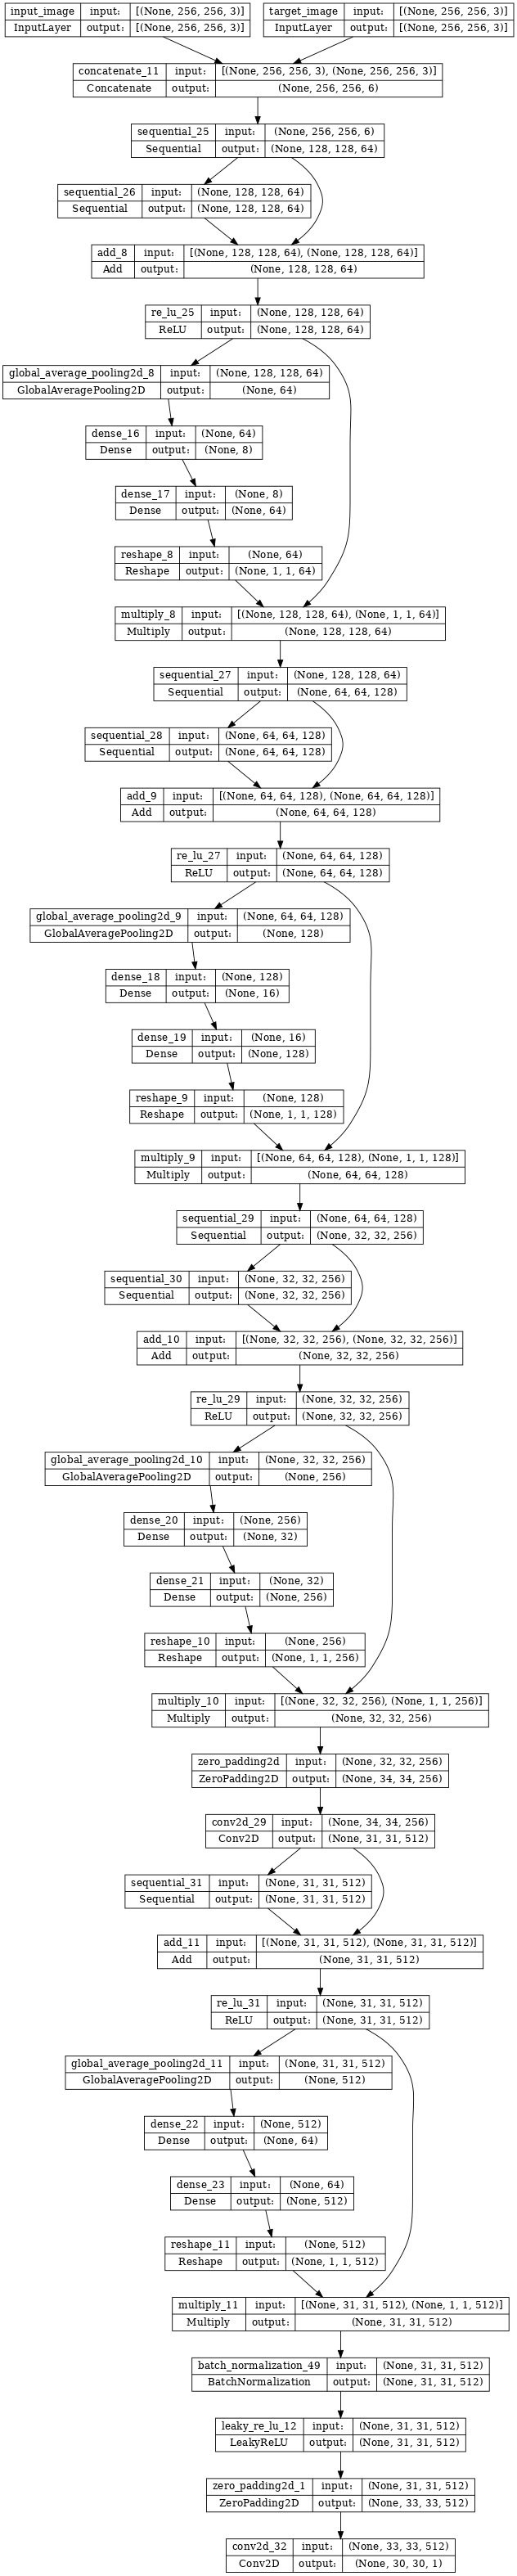

In [37]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

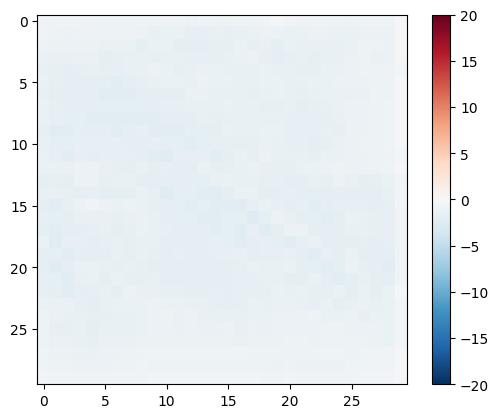

In [38]:
# print(gen_output)
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
# print(disc_out)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [39]:
# def discriminator_loss(disc_real_output, disc_generated_output):
#     # real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

#     # generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

#     # total_disc_loss = real_loss + generated_loss

#     return backend.mean(disc_generated_output) - backend.mean(disc_real_output)

#     # return total_disc_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    total_disc_loss = tf.reduce_mean(disc_generated_output) - tf.reduce_mean(disc_real_output)
    
    return total_disc_loss

In [40]:
# generator_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

In [41]:
# generator.compile(loss=generator_loss, optimizer=generator_optimizer)
# discriminator.compile(loss=discriminator_loss, optimizer=discriminator_optimizer)

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [12]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

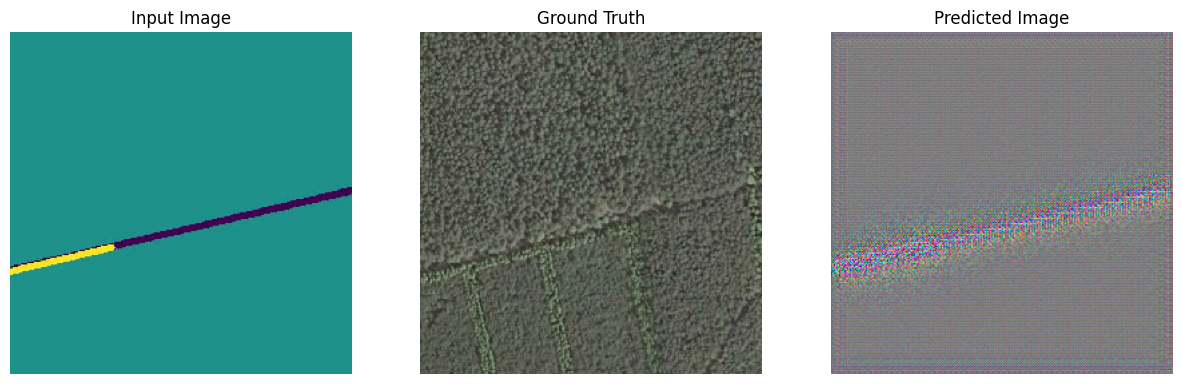

In [44]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [45]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + "train" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

summary_writer_eval = tf.summary.create_file_writer(
    log_dir + "fit/" + "eval" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

In [46]:
@tf.function
def train_step(input_image, target, apply_gradient = True):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    if apply_gradient:
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)

        for idx, grad in enumerate(discriminator_gradients):
            discriminator_gradients[idx] = tf.clip_by_value(grad, -0.01, 0.01)
            
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                    discriminator.trainable_variables))

    return gen_total_loss, gen_l1_loss, gen_gan_loss, disc_loss

    # with summary_writer.as_default():
    #     tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    #     tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    #     tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    #     tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [47]:
def fit(train_ds, test_ds, eval_dataset, epoch):
    early_stop_patience = 10
    eval_gen_loss_best = -float('inf')
    # eval_dis_loss_best = float('inf')
    early_stop_counter = 0
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    for epoch in range(epoch):
        epoch_disc_loss = 0
        epoch_gen_gan_loss = 0
        epoch_gen_l1_loss = 0
        epoch_gen_total_loss = 0
        print('TRAINING RUN ...')
        for (input_image, target) in tqdm(train_ds):
            gen_total_loss, gen_l1_loss, gen_gan_loss, disc_loss = train_step(input_image, target)
            epoch_disc_loss += disc_loss
            epoch_gen_gan_loss += gen_gan_loss
            epoch_gen_l1_loss += gen_l1_loss
            epoch_gen_total_loss += gen_total_loss

        epoch_gen_total_loss /= len(train_ds) * BATCH_SIZE    
        epoch_gen_l1_loss /= len(train_ds) * BATCH_SIZE    
        epoch_gen_gan_loss /= len(train_ds) * BATCH_SIZE    
        epoch_disc_loss /= len(train_ds) * BATCH_SIZE   
        print(f"TRAIN GAN LOSS : {epoch_gen_gan_loss}")
        print(f"TRAIN L1 LOSS : {epoch_gen_l1_loss}")
        print(f"TRAIN TOTAL LOSS : {epoch_gen_total_loss}")
        print(f"TRAIN DISC LOSS : {epoch_disc_loss}")

        generate_images(generator, example_input, example_target)

        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch) 
        checkpoint.save(file_prefix=checkpoint_prefix)

        print('EVALUATION RUN ...')
        val_gen_total_loss = 0
        val_gen_loss = 0
        val_l1_loss = 0
        val_dis_loss = 0
        for (input_image, target) in tqdm(eval_dataset):
            gen_total_loss, gen_l1_loss, gen_gan_loss, disc_loss = train_step(input_image, target, False)
            val_gen_total_loss += gen_total_loss
            val_gen_loss += gen_gan_loss
            val_l1_loss += gen_l1_loss
            val_dis_loss += disc_loss

        val_gen_total_loss /= len(eval_dataset) * BATCH_SIZE 
        val_gen_loss /= len(eval_dataset) * BATCH_SIZE 
        val_l1_loss /= len(eval_dataset) * BATCH_SIZE 
        val_dis_loss /= len(eval_dataset) * BATCH_SIZE 

        print(f'actual gen loss: {val_gen_loss}')
        print(f'past gen loss: {eval_gen_loss_best}')
        # print(f'actual dis loss: {val_dis_loss}')
        # print(f'past dis loss: {eval_dis_loss_best}')
        if (
            val_gen_loss > eval_gen_loss_best# or 
            # val_dis_loss < eval_dis_loss_best  
        ):
            eval_gen_loss_best = val_gen_loss
            # eval_dis_loss_best = val_dis_loss
            generator.save('generator_best_t.h5')
            discriminator.save('discriminator_best_t.h5')
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                # generator = tf.keras.models.load_model('generator_best.h5')
                # discriminator = tf.keras.models.load_model('discriminator_best.h5')
                print(f'Arrêt anticipé à l\'époque {epoch}')
                break
        
        with summary_writer_eval.as_default():
            tf.summary.scalar('gen_total_loss', val_gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', val_gen_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', val_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', val_dis_loss, step=epoch) 
        

Je commande l'entrainement pour un problème de taille de fichier afin de pouvoir le rendre au CNAM

In [17]:
# fit(train_dataset, test_dataset, eval_dataset, epoch=30)
# generator = tf.keras.models.load_model('generator_best_t.h5')
# discriminator = tf.keras.models.load_model('discriminator_best_t.h5')

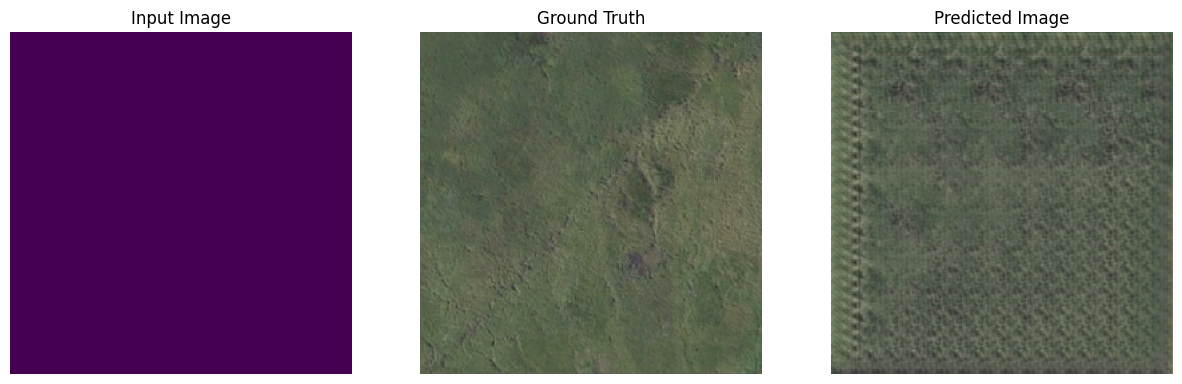

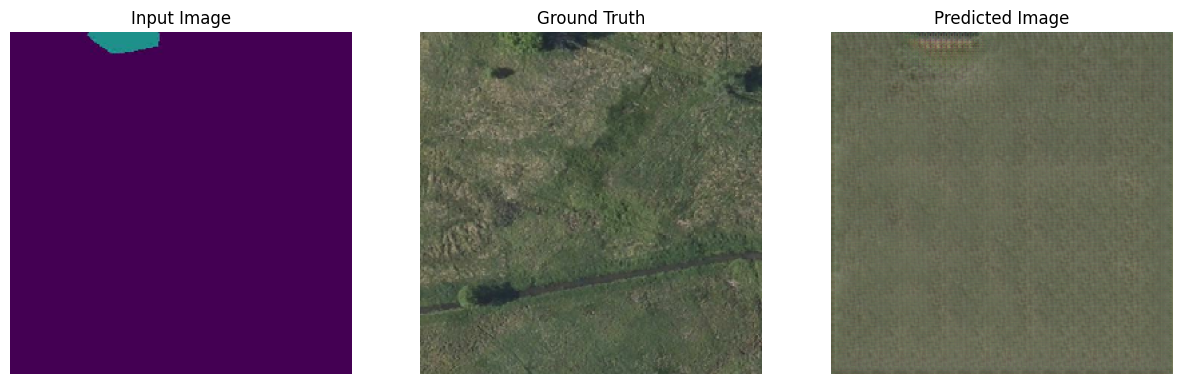

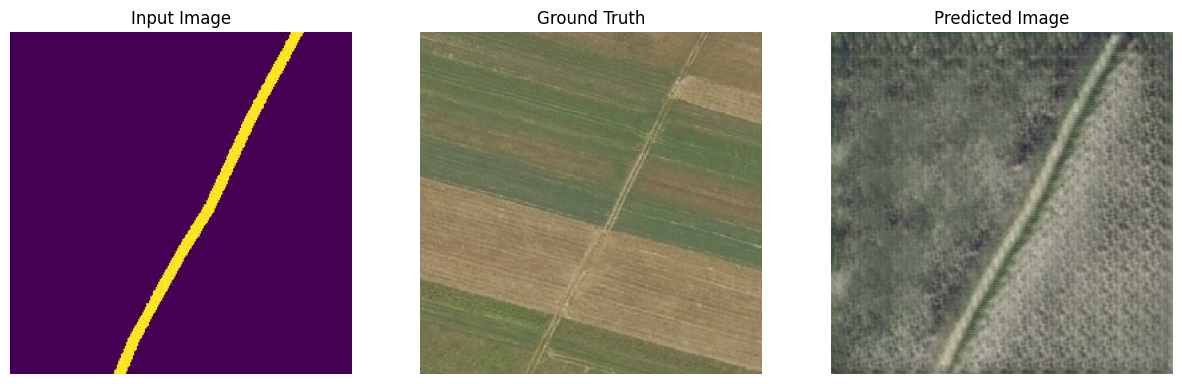

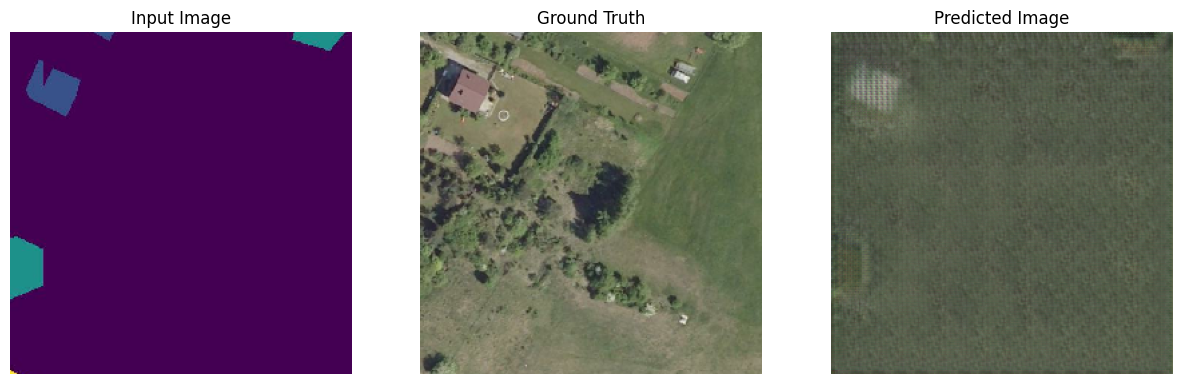

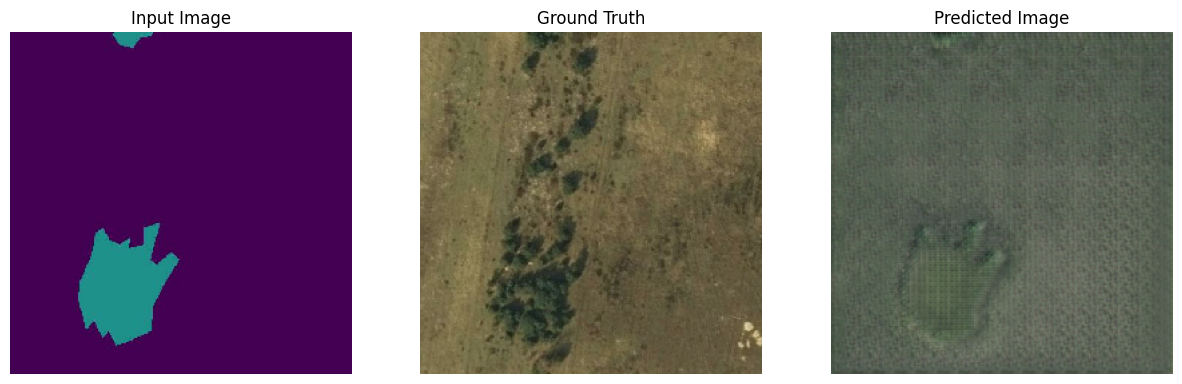

In [16]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

In [52]:
display.IFrame(
    src="http://127.0.0.1:6006",
    width="100%",
    height="1000px")

In [13]:
generator = tf.keras.models.load_model('generator_best_t.h5')
discriminator = tf.keras.models.load_model('discriminator_best_t.h5')

In [15]:
base_model = VGG19(weights='imagenet', include_top=False)
base_model.trainable = False
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv4').output)


def load_and_preprocess_image(image_array):
    img_array = tf.image.resize(image_array, (224, 224))
    img_array = np.array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

cos_similarite = 0
distance_l1 = 0
distance_l2 = 0
for (input_image, target) in tqdm(test_dataset):
    prediction = generator(input_image, training=True)
    preprocess_predi = load_and_preprocess_image(prediction[0].numpy())
    preprocess_tar = load_and_preprocess_image(target[0].numpy())

    feature_maps_predi = model.predict(preprocess_predi, verbose=0)
    feature_maps_tar = model.predict(preprocess_tar, verbose=0)

    feature_vector_predi = feature_maps_predi.flatten()
    feature_vector_tar = feature_maps_tar.flatten()

    cos_similarite += cosine_similarity([feature_vector_predi], [feature_vector_tar])[0][0]
    distance_l1 += np.sum(np.abs(prediction[0].numpy() - target[0].numpy()))
    distance_l2 += np.sqrt(np.sum((prediction[0].numpy() - target[0].numpy()) ** 2))

print("Similarité cosinus moyenne entre les deux images:", cos_similarite / len(test_dataset))
print("Distance L1 moyenne entre les vecteurs de caractéristiques:", distance_l1 / len(test_dataset))
print("Distance L2 moyenne entre les vecteurs de caractéristiques:", distance_l2 / len(test_dataset))



100%|██████████| 1602/1602 [04:52<00:00,  5.47it/s]

Similarité cosinus moyenne entre les deux images: 0.998516129494904
Distance L1 moyenne entre les vecteurs de caractéristiques: 45235.23061322273
Distance L2 moyenne entre les vecteurs de caractéristiques: 125.17565315879983
